### Imports 

In [66]:
import glob
import re
import itertools
import numpy as np
import nibabel as nb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy import stats
from nilearn import image, masking, plotting
from ipywidgets import interact, interactive, fixed

%matplotlib inline
plt.style.use('ggplot')

In [2]:
subject_list = range(101,115)+[116]+range(118,130)

In [410]:
len(subject_list)

27

In [ ]:
## MAY BE LEGACY

def get_gm_data(image_stack):
    data_array = []
    for i in image_stack:
        i_data = i.get_data().ravel()
        i_data = i_data[i_data.nonzero()]
        data_array.append(i_data)
    return data_array

### Load Data

Get the paths to the lag maps and GM masks.

In [4]:
regions = [('aifo','Aifo'), ('dlpfc','Dlpfc'), ('s1','Sham')]
scans = [('baseline', 'rest_1'), ('post1', 'rest_2'), ('post2', 'rest_3')]

In [5]:
lag_map_fpt = '/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/{0}/sub*_{0}_{1}_minimal_lag10.nii.gz'
gm_mask_fpt = '/home/despo/dlurie/Projects/megarest_lag/analysis/sub*/{0}/sub*_{0}_{1}_minimal_gm_30p_mask.nii.gz'

In [6]:
lag_map_paths = {}
for i in itertools.product(regions, scans):
    lag_map_paths['_'.join([i[0][0], i[1][0]])] = sorted(glob.glob(lag_map_fpt.format(i[0][1], i[1][1])))

In [7]:
gm_mask_paths = {}
for i in itertools.product(regions, scans):
    gm_mask_paths['_'.join([i[0][0], i[1][0]])] = sorted(glob.glob(gm_mask_fpt.format(i[0][1], i[1][1])))

Load lag maps and GM masks.

In [8]:
lag_maps = {}
for k, v in lag_map_paths.iteritems():
    lag_maps[k] = image.smooth_img(v, None)

In [9]:
gm_masks = {}
for k, v in gm_mask_paths.iteritems():
    gm_masks[k] = image.smooth_img(v, None)

Get arrays containing only the GM voxels from each map.

In [10]:
def iter_masker(img_array, mask_array):
    out_array = []
    for idx, img_data in enumerate(img_array):
        data_masked = masking.apply_mask(img_data, mask_array[idx])
        out_array.append(data_masked)
    return out_array

In [11]:
lag_maps_gmonly = {}
for k, v in lag_maps.iteritems():
    lag_maps_gmonly[k] = iter_masker(v, gm_masks[k])

### Generate and save lag difference maps (post1 - baseline)

In [22]:
def make_difference_imgs(pre_stack, post_stack):
    img_diffs = []
    for idx, pre_img in enumerate(pre_stack):
        diff_img = image.math_img('np.subtract(img2, img1)', img2=post_stack[idx], img1=pre_img)
        img_diffs.append(diff_img)
    return img_diffs

In [26]:
diff_maps = {}
for stim_site in regions:
    baseline_maps = lag_maps['_'.join([stim_site[0], 'baseline'])]
    post1_maps = lag_maps['_'.join([stim_site[0], 'post1'])]
    diff_maps[stim_site[0]] = make_difference_imgs(baseline_maps, post1_maps)

In [ ]:
def save_diff_images(diff_img_array, subject_list, condition):
    for idx, sub_id in enumerate(subject_list):
        out_path = '/home/despo/dlurie/Projects/megarest_lag/analysis/sub{0}/{1}/sub{0}_{1}_minimal_r2minusr1_diffmap.nii.gz'.format(str(sub_id), condition)
        nb.save(diff_img_array[idx], out_path)
        out_path_smoothed = '/home/despo/dlurie/Projects/megarest_lag/analysis/sub{0}/{1}/sub{0}_{1}_minimal_r2minusr1_diffmap_smoothed5.nii.gz'.format(str(sub_id), condition)
        smoothed_img = image.smooth_img(diff_img_array[idx], 5)
        nb.save(smoothed_img, out_path_smoothed)

In [ ]:
diff_maps = {}
for stim_site in regions:
    save_diff_images(diff_maps[stim_site[0]], subject_list, stim_site[1])

### Plot Lag Distributions (per subject)

In [ ]:
def dist_grid(data_1, data_2, data_3, subject_list, n_cols, title):
    """
    For each subject, plot the distribution of 3 variables. Arrange subplots as a grid
    """
    # Set up the grid
    n_subs = len(subject_list)
    n_rows = int(np.ceil(n_subs/(float(n_cols))))
    
    # Set up the plot axes
    ax_idx_x= []
    ax_idx_y= []
    for idx_x in range(n_rows):
        for idx_y in range(n_cols):
            ax_idx_y.append(idx_y)
            ax_idx_x.append(idx_x)
            
    # Define variable/color/label pairings
    colors = ['orangered', 'darkorchid', 'deepskyblue']
    labels = ['Baseline', 'Post 1', 'Post 2']
    variables = zip([data_1, data_2, data_3], colors, labels)
    
    # Initialize the figure
    f, axarr = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(13,2*n_rows))
    
    # Create a subplot for each subject
    for idx, sub_id in enumerate(subject_list):
        # Loop through variables
        for var in variables:
            sns.distplot(var[0][idx], kde=False, hist=True, color=var[1], norm_hist=True,
                         ax=axarr[ax_idx_x[idx], ax_idx_y[idx]], label=var[2],
                         hist_kws={'histtype': "step", 'alpha': 1, 'linewidth': 1})
        axarr[ax_idx_x[idx], ax_idx_y[idx]].legend()
        axarr[ax_idx_x[idx], ax_idx_y[idx]].set_yscale('log')
        axarr[ax_idx_x[idx], ax_idx_y[idx]].set_title('Subject '+str(sub_id), fontsize=10)
    plt.xlim(-10, 10)
    plt.suptitle(title, y=1.01, fontsize=18)
    plt.tight_layout()

#### AiFO

In [ ]:
dist_grid(lag_maps_gmonly['aifo_baseline'], lag_maps_gmonly['aifo_post1'], lag_maps_gmonly['aifo_post2'],
          subject_list, 3, "Whole-Brain Lag Distribution (aIfO Stimulation)")

#### dlPFC

In [ ]:
dist_grid(lag_maps_gmonly['dlpfc_baseline'], lag_maps_gmonly['dlpfc_post1'], lag_maps_gmonly['dlpfc_post2'],
          subject_list, 3, "Whole-Brain Lag Distribution (dlPFC Stimulation)")

#### S1

In [ ]:
dist_grid(lag_maps_gmonly['s1_baseline'], lag_maps_gmonly['s1_post1'], lag_maps_gmonly['s1_post2'],
          subject_list, 3, "Whole-Brain Lag Distribution (S1 Stimulation)")

## Under-Coil Analysis

### Prepare data

Load and resample the TMS ROIs

In [28]:
def resample_rois(condition_4d, condition_roi_paths):
    out_4d = []
    for idx, sub_img in enumerate(condition_4d):
        roi_path = condition_roi_paths[idx]
        roi_img = image.smooth_img(roi_path, None)
        roi_img_resampled = image.resample_to_img(roi_img, sub_img, interpolation='nearest')
        out_4d.append(roi_img_resampled)
    return out_4d

In [29]:
rois = [('aifo', 'Aifo', 'Aifo'), ('dlpfc', 'Dlpfc', 'Dlpfc'), ('s1', 'Sham','S1_L')]

In [30]:
roi_fpt = '/home/despo/dlurie/Projects/megarest_lag/data/sub*/{0}/sub*_{1}_roi.nii.gz'
roi_paths = {}
for i in rois:
    roi_paths[i[0]] = sorted(glob.glob(roi_fpt.format(i[1], i[2])))

In [31]:
roi_imgs = {}
for i in itertools.product(regions, regions): # roi location, scan session
    roi_imgs['_'.join([i[0][0], i[1][0]])] = resample_rois(lag_maps[i[1][0]+'_baseline'], roi_paths[i[0][0]])

Load the pre-computed mean CBF values (per scan, per ROI)

In [32]:
tms_rois = ['aifo_tms', 'dlpfc_tms', 's1_tms']
cbf_rois = ['aifo_cbf', 'dlpfc_cbf', 's1_cbf']
cbf_cols = ['_'.join(i) for i in list(itertools.product(tms_rois, cbf_rois))]
cbf_cols = ['sub_id'] + cbf_cols

In [33]:
cbf_data_fpt = '/home/despo/cgratton/data/MegaRest.TMS/Data/ASLdata/global_norm/Alldata_undercoil_CBFmean_spss_{}.txt'
cbf_data = {'baseline': 'pre', 'post1': 'post1', 'post2': 'post2'}
for k, v in cbf_data.iteritems():
    cbf_data[k] = pd.read_csv(cbf_data_fpt.format(v), sep='\t', usecols=range(0,10),
                          index_col=0, names=cbf_cols, header=0)

Build a multi-index DF to hold both lag and CBF data.

In [35]:
roi_list = ['aifo', 'dlpfc', 's1']
scan_list = ['baseline', 'post1', 'post2']
measures = ['mean_lag', 'mean_cbf']

under_coil_ix_rows = [list(i) for i in itertools.product(subject_list, roi_list, scan_list, roi_list, measures)]

under_coil_mindex = pd.MultiIndex.from_arrays(np.array(under_coil_ix_rows).T,
                                              names=['sub_id', 'stim_roi', 'scan','data_roi', 'measure'])
under_coil_df = pd.DataFrame(index=under_coil_mindex)
under_coil_df['value'] = np.nan

Populate mean lag values.

In [36]:
for i in itertools.product(roi_list, scan_list, roi_list):
    lag_map_array = lag_maps['_'.join([i[0], i[1]])]
    roi_img_array = roi_imgs['_'.join([i[2], i[0]])]
    stim_roi = i[0]
    scan = i[1]
    data_roi = i[2]
    for idx, sub_id in enumerate(subject_list):
        sub_id = str(sub_id)
        masked_data = masking.apply_mask(lag_map_array[idx], roi_img_array[idx])
        under_coil_df.ix[sub_id, stim_roi, scan, data_roi, 'mean_lag'] = np.mean(masked_data, dtype='float64')

In [37]:
for i in itertools.product(roi_list, scan_list, roi_list):
    cbf_df = cbf_data[scan]
    stim_roi = i[0]
    scan = i[1]
    data_roi = i[2]
    for idx, sub_id in enumerate(subject_list):
        cbf_col = '{0}_tms_{1}_cbf'.format(stim_roi, data_roi)
        cbf_val = cbf_df.ix[sub_id, cbf_col]
        under_coil_df.ix[str(sub_id), stim_roi, scan, data_roi, 'mean_cbf'] = cbf_val

Helper function to query the data frame.

In [38]:
def grab_from_df(subject_list, stim_roi, scan, data_roi, val_col):
    dseries = []
    for sub_id in subject_list:
        val = under_coil_df.loc[str(sub_id), stim_roi, scan, data_roi, val_col].value
        dseries.append(val)
    return pd.Series(dseries, index=subject_list)

Flatten the data frame for plotting.

In [39]:
under_coil_dflat = under_coil_df.reset_index()

Calculate changes (pre/post) changes in lag and CBF under the coil.

In [40]:
stim_data_baseline = under_coil_dflat[(under_coil_dflat['stim_roi'] == under_coil_dflat['data_roi']) &
                             (under_coil_dflat['scan'] == 'baseline')].set_index('sub_id')

In [41]:
all_mean_lag_baseline = stim_data_baseline[stim_data_baseline['measure'] == 'mean_lag']['value']
all_mean_cbf_baseline = stim_data_baseline[stim_data_baseline['measure'] == 'mean_cbf']['value']

In [42]:
stim_data_post1 = under_coil_dflat[(under_coil_dflat['stim_roi'] == under_coil_dflat['data_roi']) & 
                                   (under_coil_dflat['scan'] == 'post1')].set_index('sub_id')

In [43]:
all_mean_lag_post1 = stim_data_post1[stim_data_post1['measure'] == 'mean_lag']['value']
all_mean_cbf_post1 = stim_data_post1[stim_data_post1['measure'] == 'mean_cbf']['value']

In [44]:
lag_diff = np.subtract(all_mean_lag_post1, all_mean_lag_baseline)

In [45]:
cbf_diff = np.subtract(all_mean_cbf_post1, all_mean_cbf_baseline)

Create data frames containing under-coil CBF and lag differences, organized by stimulation site.

In [165]:
def make_diff_df(measure):
    diff_df = pd.DataFrame()
    for stim_site in regions:
        measure_name = '_'.join(['mean', measure])
        col_data = (grab_from_df(subject_list, stim_site[0], 'post1', stim_site[0], measure_name) - 
                    grab_from_df(subject_list, stim_site[0], 'baseline', stim_site[0], measure_name))
        diff_df[stim_site[0]] = col_data
    diff_df['sub_id'] = col_data.index.values
    return diff_df

In [185]:
cbf_diff_df = make_diff_df('cbf')
lag_diff_df = make_diff_df('lag')

Re-name columns so they look nice in figures.

In [186]:
cbf_diff_df.columns = ['aI/fO', 'dlPFC', 'S1', 'sub_id']
lag_diff_df.columns = ['aI/fO', 'dlPFC', 'S1', 'sub_id']

Melt the difference data frames so they are wide.

In [187]:
cbf_diff_df_wide = pd.melt(cbf_diff_df, value_name='cbf', var_name='stim_site', id_vars='sub_id')
lag_diff_df_wide = pd.melt(lag_diff_df, value_name='lag', var_name='stim_site', id_vars='sub_id')

### Plot CBF changes

In [302]:
scatter_colors = ['#1b9e77', '#d95f02', '#7570b3']

In [303]:
scatter_pallette = sns.color_palette(scatter_colors)

In [428]:
stats.ttest_1samp(lag_diff_df_wide[lag_diff_df_wide['stim_site']=='S1']['lag'].values, 0)

Ttest_1sampResult(statistic=1.8701899266307631, pvalue=0.072756720410480744)

In [444]:
stats.ttest_1samp(cbf_diff_df_wide[cbf_diff_df_wide['stim_site']=='dlPFC']['cbf'].values, 0)

Ttest_1sampResult(statistic=3.096351412611996, pvalue=0.0046520938857097099)

In [ ]:
stats.ttest_1samp()

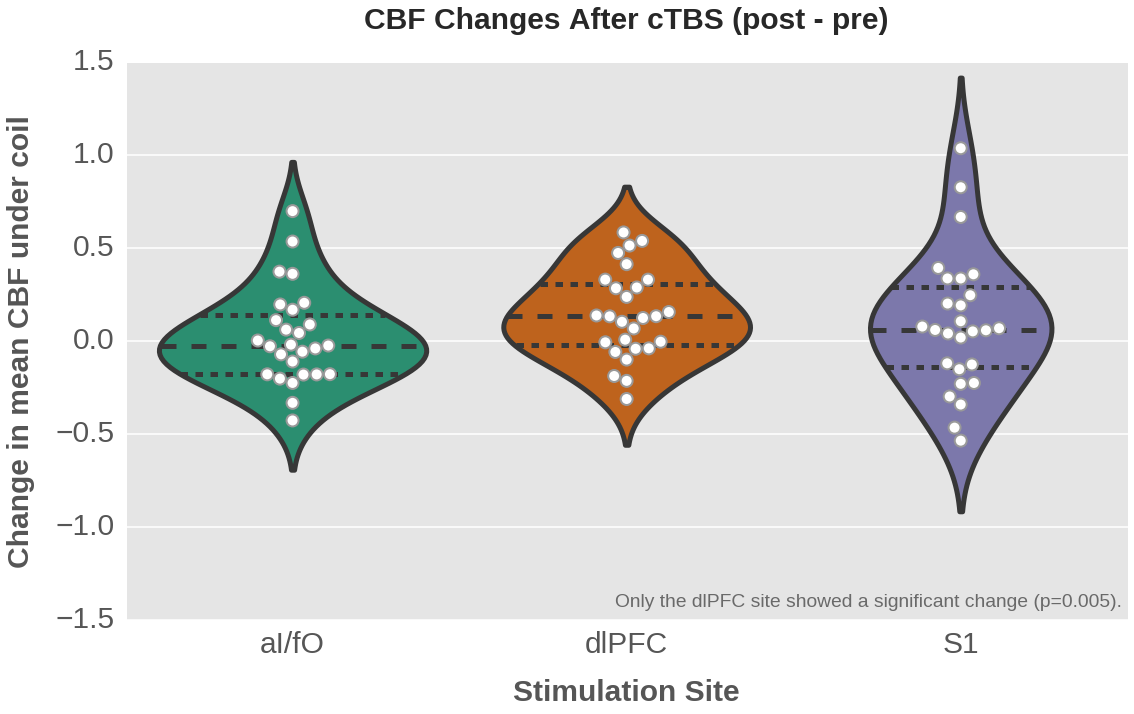

In [459]:
fig, ax = plt.subplots(1, figsize=(16,10))
sns.violinplot(data=cbf_diff_df_wide, x='stim_site', y='cbf', inner='quartile', palette=scatter_pallette, linewidth=5)
s = sns.swarmplot(data=cbf_diff_df_wide, x='stim_site', y='cbf', edgecolor='gray',
                  size=12, linewidth=2, color='w')
plt.tick_params(which='both', labelsize=30)
ax.set_title('CBF Changes After cTBS (post - pre)', fontsize=30, fontweight='bold',y=1.05)
ax.set_ylabel('Change in mean CBF under coil', fontsize=30, labelpad=20, fontweight='bold')
ax.set_xlabel('Stimulation Site', fontsize=30, labelpad=20, fontweight='bold')
fig.text(.505, 0.15, "Only the dlPFC site showed a significant change (p=0.005).",horizontalalignment='left', verticalalignment='center',
         transform = ax.transAxes, color='dimgray')
ax.set_ylim(-1.5, 1.5)
plt.savefig('figures/cbf_change.svg', facecolor='w')

### Plot lag changes

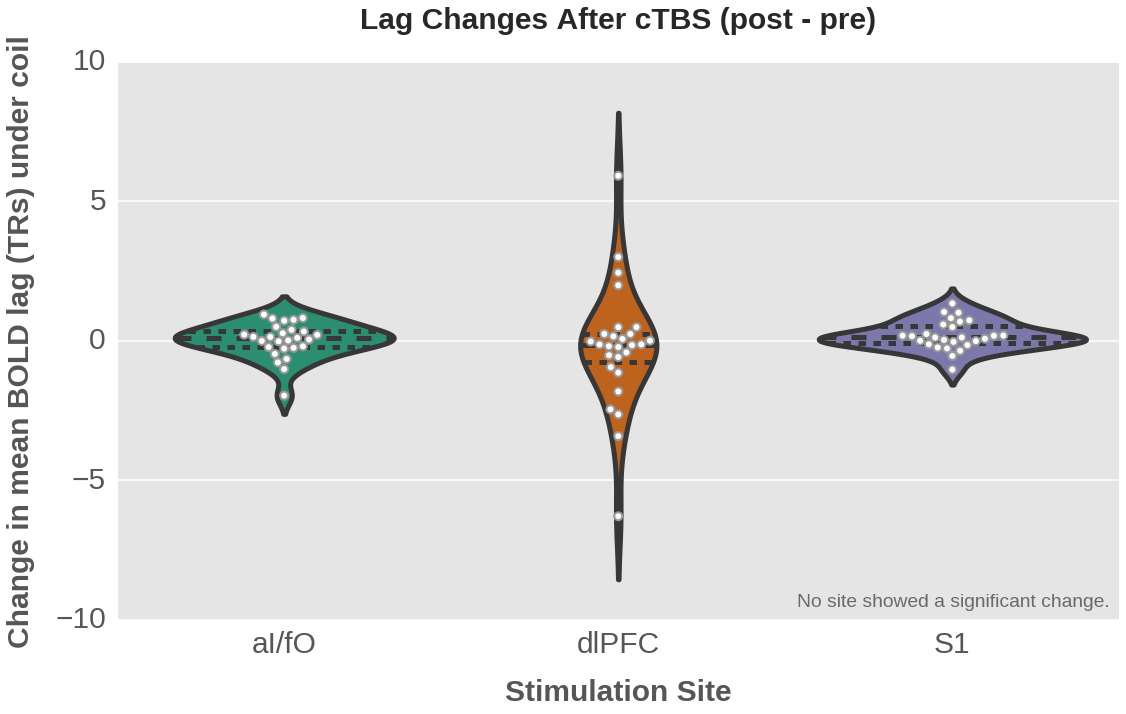

In [440]:
fig, ax = plt.subplots(1, figsize=(16,10))
sns.violinplot(data=lag_diff_df_wide, x='stim_site', y='lag', inner='quartile', palette=scatter_pallette, linewidth=5)
s = sns.swarmplot(data=lag_diff_df_wide, x='stim_site', y='lag', edgecolor='gray',
                  size=8, linewidth=2, color='w')
plt.tick_params(which='both', labelsize=30)
ax.set_title('Lag Changes After cTBS (post - pre)', fontsize=30, fontweight='bold',y=1.05)
ax.set_ylabel('Change in mean BOLD lag (TRs) under coil', fontsize=30, labelpad=20, fontweight='bold')
ax.set_xlabel('Stimulation Site', fontsize=30, labelpad=20, fontweight='bold')
ax.set_ylim(-10, 10)
fig.text(.67, 0.15, "No site showed a significant change.",horizontalalignment='left', verticalalignment='center',
         transform = ax.transAxes, color='dimgray')
plt.savefig('figures/lag_change.svg', facecolor='w')

### Plot CBF changes against lag changes.

In [76]:
scatter_colors = []
for i in stim_data_post1['stim_roi'].values:
    if i == 'aifo':
        scatter_colors.append(scatter_colors[0])
    elif i == 'dlpfc':
        scatter_colors.append(scatter_colors[1])
    elif i == 's1':
        scatter_colors.append(scatter_colors[2])

In [77]:
import matplotlib.patches as mpatches

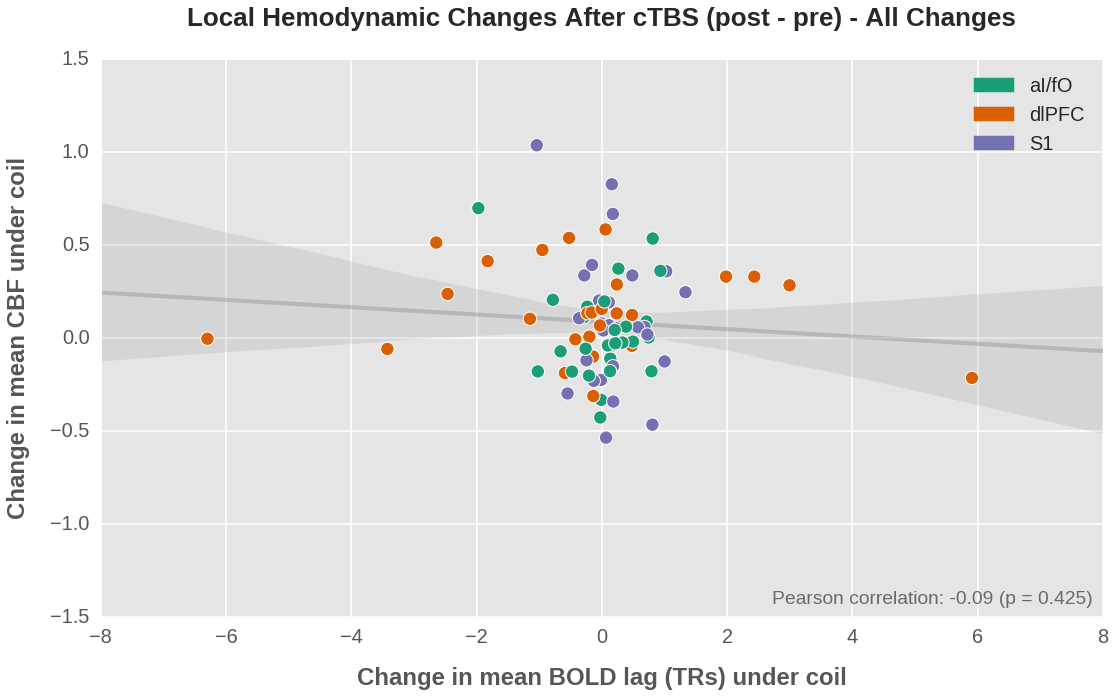

In [419]:
fig, ax = plt.subplots(1, figsize=(16,10))
s = ax.scatter(lag_diff, cbf_diff, c=scatter_colors, s=180, edgecolors='w', linewidths=1)
plt.setp(s, zorder=10000)

a = sns.regplot(lag_diff, cbf_diff, line_kws={'alpha':0.35}, color='gray')
a.set_xlim(-8, 8)
a.set_ylim(-1.5, 1.5)
plt.setp(a.artists, zorder=1)

corr, pval = stats.pearsonr(lag_diff, cbf_diff)
reg_label = "Pearson correlation: {0} (p = {1})".format(np.around(corr, decimals=3),
                                                        np.around(pval, decimals=3))

fig.text(.802, 0.15, reg_label,horizontalalignment='center', verticalalignment='center',
         transform = ax.transAxes, color='dimgray')

plt.tick_params(which='both', labelsize=20)
ax.set_title('Local Hemodynamic Changes After cTBS (post - pre) - All Changes', fontsize=26, fontweight='bold',y=1.05)
ax.set_ylabel('Change in mean CBF under coil', fontsize=24, labelpad=20, fontweight='bold')
ax.set_xlabel('Change in mean BOLD lag (TRs) under coil', fontsize=24, labelpad=20, fontweight='bold')
aifo_patch = mpatches.Patch(color='#1b9e77', label='aI/fO')
dlpfc_patch = mpatches.Patch(color='#d95f02', label='dlPFC')
s1_patch = mpatches.Patch(color='#7570b3', label='S1')
plt.legend(handles=[aifo_patch, dlpfc_patch, s1_patch], fontsize=20)
plt.savefig('figures/change_by_change.svg', facecolor='w')

### Plot Lag/CBF relationship for CBF increases

In [385]:
cbf_higher = (cbf_diff >=0).values
cbf_higher_cbf_diff = cbf_diff[cbf_higher]
cbf_higher_lag_diff = lag_diff[cbf_higher]

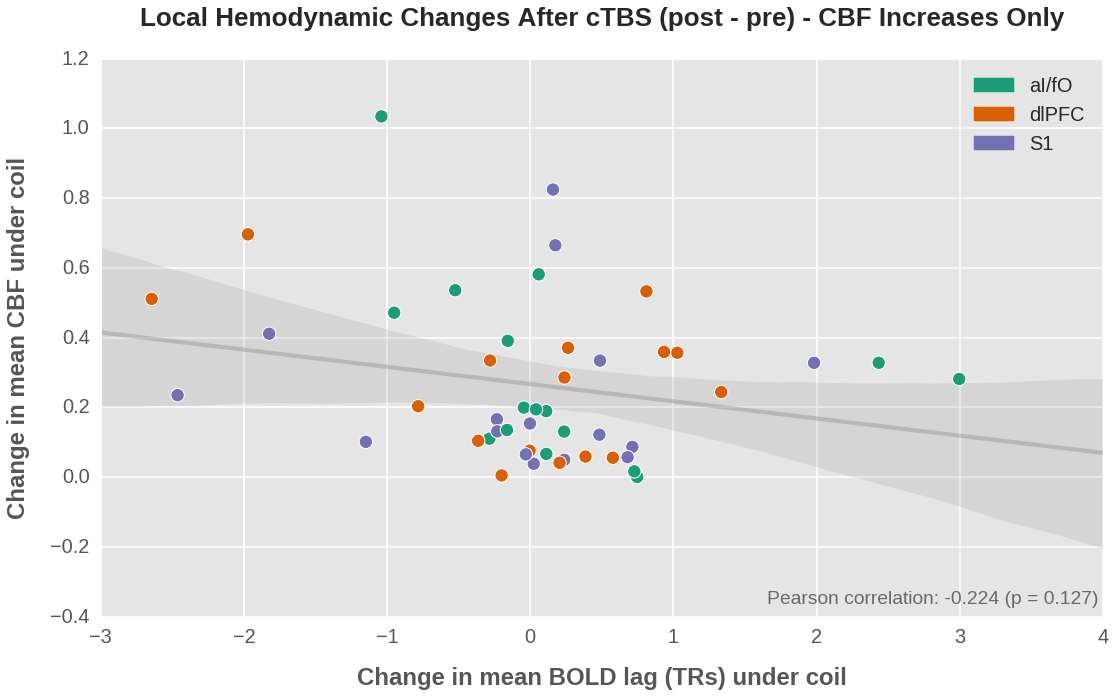

In [418]:
fig, ax = plt.subplots(1, figsize=(16,10))
s = ax.scatter(cbf_higher_lag_diff, cbf_higher_cbf_diff, c=scatter_colors, s=180, edgecolors='w', linewidths=1)
plt.setp(s, zorder=10000)

a = sns.regplot(cbf_higher_lag_diff, cbf_higher_cbf_diff, line_kws={'alpha':0.35}, color='gray')
#a.set_xlim(-4, 4)
#a.set_ylim(-0.5, 1.5)
plt.setp(a.artists, zorder=1)

corr, pval = stats.pearsonr(lag_diff[cbf_higher], cbf_diff[cbf_higher])
reg_label = "Pearson correlation: {0} (p = {1})".format(np.around(corr, decimals=3),
                                                        np.around(pval, decimals=3))

fig.text(.802, 0.15, reg_label,horizontalalignment='center', verticalalignment='center',
         transform = ax.transAxes, color='dimgray')

plt.tick_params(which='both', labelsize=20)
ax.set_title('Local Hemodynamic Changes After cTBS (post - pre) - CBF Increases Only', fontsize=26, fontweight='bold',y=1.05)
ax.set_ylabel('Change in mean CBF under coil', fontsize=24, labelpad=20, fontweight='bold')
ax.set_xlabel('Change in mean BOLD lag (TRs) under coil', fontsize=24, labelpad=20, fontweight='bold')
aifo_patch = mpatches.Patch(color='#1b9e77', label='aI/fO')
dlpfc_patch = mpatches.Patch(color='#d95f02', label='dlPFC')
s1_patch = mpatches.Patch(color='#7570b3', label='S1')
plt.legend(handles=[aifo_patch, dlpfc_patch, s1_patch], fontsize=20)
plt.savefig('figures/change_by_change_pos.svg', facecolor='w')

### Plot Lag/CBF relationship for CBF increases

In [387]:
cbf_lower = (cbf_diff <=0).values
cbf_lower_cbf_diff = cbf_diff[cbf_lower]
cbf_lower_lag_diff = lag_diff[cbf_lower]

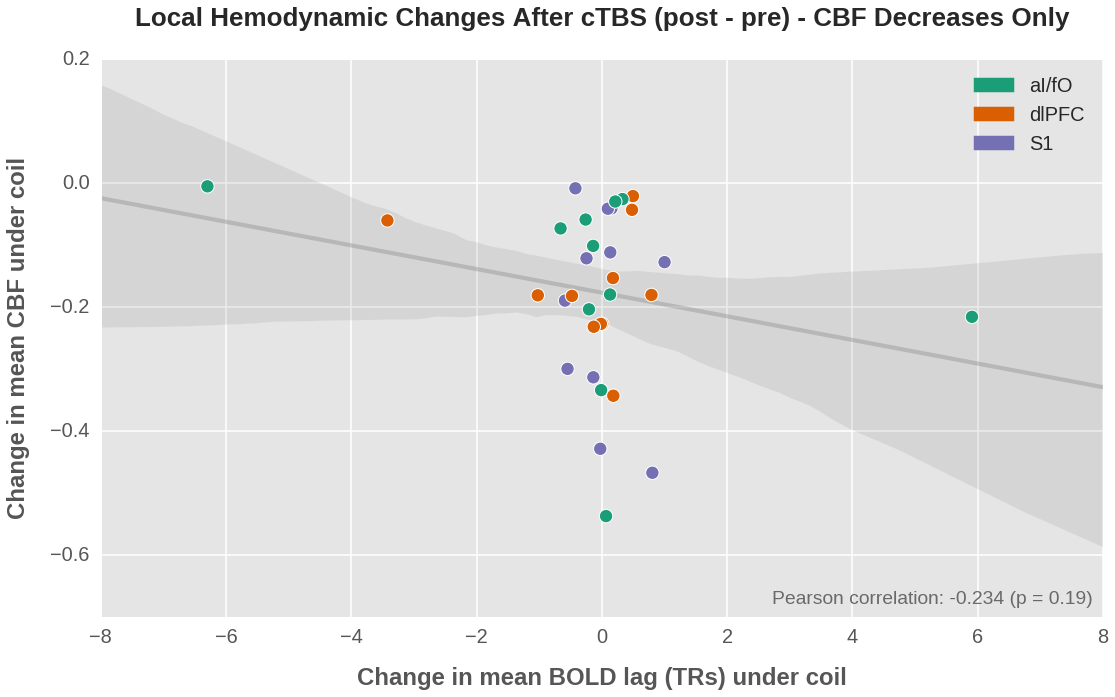

In [416]:
fig, ax = plt.subplots(1, figsize=(16,10))
s = ax.scatter(cbf_lower_lag_diff, cbf_lower_cbf_diff, c=scatter_colors, s=180, edgecolors='w', linewidths=1)
plt.setp(s, zorder=10000)

a = sns.regplot(cbf_lower_lag_diff, cbf_lower_cbf_diff, line_kws={'alpha':0.35}, color='gray')
#a.set_xlim(-4, 4)
#a.set_ylim(-0.5, 1.5)
plt.setp(a.artists, zorder=1)

corr, pval = stats.pearsonr(lag_diff[cbf_lower], cbf_diff[cbf_lower])
reg_label = "Pearson correlation: {0} (p = {1})".format(np.around(corr, decimals=3),
                                                        np.around(pval, decimals=3))

fig.text(.802, 0.15, reg_label,horizontalalignment='center', verticalalignment='center',
         transform = ax.transAxes, color='dimgray')

plt.tick_params(which='both', labelsize=20)
ax.set_title('Local Hemodynamic Changes After cTBS (post - pre) - CBF Decreases Only', fontsize=26, fontweight='bold',y=1.05)
ax.set_ylabel('Change in mean CBF under coil', fontsize=24, labelpad=20, fontweight='bold')
ax.set_xlabel('Change in mean BOLD lag (TRs) under coil', fontsize=24, labelpad=20, fontweight='bold')
aifo_patch = mpatches.Patch(color='#1b9e77', label='aI/fO')
dlpfc_patch = mpatches.Patch(color='#d95f02', label='dlPFC')
s1_patch = mpatches.Patch(color='#7570b3', label='S1')
plt.legend(handles=[aifo_patch, dlpfc_patch, s1_patch], fontsize=20)
plt.savefig('figures/change_by_change_neg.svg', facecolor='w')

(-0.23376464986196732, 0.19042437174550927)


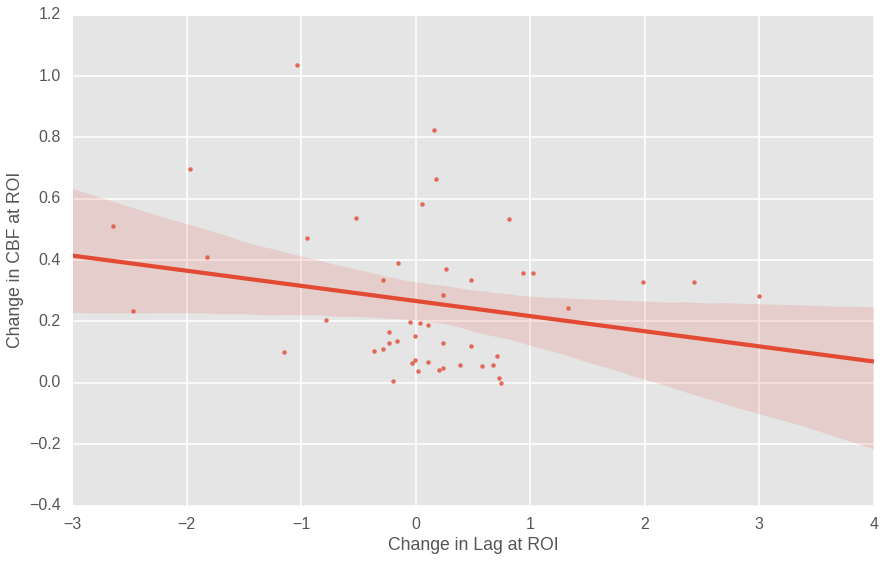

In [371]:
print(str(stats.pearsonr(foo, bar)))
sns.regplot(cbf_higher_lag_diff, cbf_higher_cbf_diff)
plt.ylabel('Change in CBF at ROI')
plt.xlabel('Change in Lag at ROI')

In [53]:
cbf_lower = (cbf_diff <=0).values
foo = cbf_diff[cbf_lower].values
bar = lag_diff[cbf_lower].values

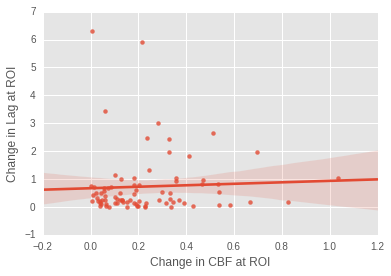

In [55]:
## print(str(stats.pearsonr(np.absolute(cbf_diff), np.absolute(lag_diff))))
sns.regplot(np.absolute(cbf_diff), np.absolute(lag_diff))
plt.xlabel('Change in CBF at ROI')
plt.ylabel('Change in Lag at ROI')

In [ ]:
sns.regplot(dists_df_fd['value'], dists_df_any['value'])
plt.xlabel('Mean FD')
plt.ylabel('% voxels > +/- 2s')

In [57]:
g = sns.FacetGrid(rois_dflat_lag, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('Mean lag within ROI')

NameError: name 'rois_dflat_lag' is not defined

In [81]:
sns.FacetGrid(

TypeError: __init__() takes at least 2 arguments (1 given)

In [ ]:
g = sns.FacetGrid(rois_dflat_cbf_all, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('Mean CBF within ROI')

In [ ]:
print(str(stats.pearsonr(rois_dflat_cbf_all['value'], rois_dflat_lag_all['value'])))
sns.regplot(rois_dflat_cbf_all['value'], rois_dflat_lag_all['value'])
plt.xlabel('Mean CBF at ROI')
plt.ylabel('Mean Lag at ROI')

In [ ]:
print(str(stats.pearsonr(rois_dflat_cbf_pre['value'], rois_dflat_lag_pre['value'])))
sns.regplot(rois_dflat_cbf_pre['value'], rois_dflat_lag_pre['value'])
plt.xlabel('Mean CBF at ROI')
plt.ylabel('Mean Lag at ROI')

In [ ]:
print(str(stats.pearsonr(rois_dflat_cbf_dlpfc['value'], rois_dflat_lag_dlpfc['value'])))
sns.regplot(rois_dflat_cbf_dlpfc['value'], rois_dflat_lag_dlpfc['value'])
plt.xlabel('Mean CBF at ROI')
plt.ylabel('Mean Lag at ROI')

In [ ]:
g = sns.FacetGrid(rois_dflat_cbf, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', linewidth=5, palette="Set2",);
g.add_legend()
g.set_ylabels('Mean lag within ROI')

In [ ]:
sns.set_context(rc={"lines.linewidth": 0.75})

In [ ]:
g = sns.FacetGrid(under_coil_dflat, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "mean_lag_at_roi", 'roi', linewidth=5, palette="Set2",);
g.add_legend()
g.set_ylabels('Mean lag within ROI')

### Load and resample CBF images.

In [ ]:
aifo_rest1_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Aifo/Analysis/ASL_new/Block01/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
aifo_rest2_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Aifo/Analysis/ASL_new/Block02/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
aifo_rest3_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Aifo/Analysis/ASL_new/Block03/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]

dlpfc_rest1_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Dlpfc/Analysis/ASL_new/Block01/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
dlpfc_rest2_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Dlpfc/Analysis/ASL_new/Block02/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
dlpfc_rest3_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Dlpfc/Analysis/ASL_new/Block03/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]

sham_rest1_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Sham/Analysis/ASL_new/Block01/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
sham_rest2_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Sham/Analysis/ASL_new/Block02/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]
sham_rest3_mean_cbf_paths = ['/home/despo/cgratton/data/MegaRest.TMS/Data/{}_Sham/Analysis/ASL_new/Block03/mask_files/norm_scCBF_timeseries_mask.nii.gz'.format(str(sub_id)) for sub_id in subject_list]

### Check for motion confound

In [ ]:
sub101_fd = compute_FD('/home/despo/dlurie/Projects/megarest_lag/data/sub102/Aifo/sub102_Aifo_rest_1_motion_params.txt', 'degrees')

In [ ]:
np.mean(sub101_fd)

In [ ]:
mp_test['Dmotion'][0][0].shape

In [ ]:
mp_test.keys()

In [ ]:
np.io.('/home/despo/arielle/megarest_sc/data/motion_params/101/motion_info_Aifo_FD_thr0.2.mat')

In [ ]:
plotting.plot_stat_map('/home/despo/dlurie/Projects/megarest_lag/analysis/sub110/Aifo/sub110_Aifo_minimal_r2minusr1_diffmap_smoothed5.nii.gz'
                       , bg_img=None, display_mode='z', black_bg=True)

### TO CLEAN- Plot changes in extreme leads/lags

In [345]:
def count_extremes(sub_data, thresh):
    n_nonzero = np.count_nonzero(sub_data)
    n_greater = np.count_nonzero(sub_data <= -thresh)
    n_lesser = np.count_nonzero(sub_data >= thresh)
    pct_lead = np.true_divide(n_greater, n_nonzero)
    pct_lag = np.true_divide(n_lesser, n_nonzero)
    return pct_lead, pct_lag

In [346]:
def compute_FD(file, units):
    """

    :rtype: object
    """
    import numpy as np

    if units == 'radians' or units == 'Radians':
        factor = 1
    elif units == 'degrees' or units == 'Degrees':
        factor = (np.pi / 180) * 50

    MP = np.loadtxt(file)
    AbsMotDiff = abs(np.diff(MP, axis=0))

    Trans = AbsMotDiff[:, 0:3]
    Rot = AbsMotDiff[:, 3:6]
    FD = np.sum(Trans, axis=1) + np.sum(factor * Rot, axis=1)

    return FD

In [347]:
roi_list = ['aifo', 'dlpfc', 's1']
scan_list = ['rest1', 'rest2', 'rest3']
measures = ['pct_big_lead', 'pct_big_lag', 'pct_big_any', 'mean_fd', 'mean_lag']

row_store = []
for subject in subject_list:
    for roi in roi_list:
        for scan in scan_list:
            for measure in measures:
                row = [str(subject), roi, scan, measure]
                row_store.append(row)

dists_df_mindex = pd.MultiIndex.from_arrays(np.array(row_store).T, names=['sub_id', 'roi', 'scan', 'measure'])
dists_dframe = pd.DataFrame(index=dists_df_mindex)
dists_dframe['value'] = np.nan

In [348]:
input_arrays =[[aifo_rest1_gm_data, 'aifo', 'rest1', 'Aifo', 'rest_1'],
               [aifo_rest2_gm_data, 'aifo', 'rest2', 'Aifo', 'rest_2'],
               [aifo_rest3_gm_data, 'aifo', 'rest3', 'Aifo', 'rest_3'],
               [dlpfc_rest1_gm_data, 'dlpfc', 'rest1', 'Dlpfc', 'rest_1'],
               [dlpfc_rest2_gm_data, 'dlpfc', 'rest2', 'Dlpfc', 'rest_2'],
               [dlpfc_rest3_gm_data, 'dlpfc', 'rest3', 'Dlpfc', 'rest_3'],
               [sham_rest1_gm_data, 's1', 'rest1', 'Sham', 'rest_1'],
               [sham_rest2_gm_data, 's1', 'rest2', 'Sham', 'rest_2'],
               [sham_rest3_gm_data, 's1', 'rest3', 'Sham', 'rest_3']]

for sub_array in input_arrays:
    data_array = sub_array[0]
    roi = sub_array[1]
    scan = sub_array[2]
    condition = sub_array[3]
    scan_name = sub_array[4]
    for idx, sub_id in enumerate(subject_list):
        sub_id = str(sub_id)
        counts = count_extremes(data_array[idx], 1)
        dists_dframe.ix[sub_id, roi, scan, 'pct_big_lead'] = counts[0]
        dists_dframe.ix[sub_id, roi, scan, 'pct_big_lag'] = counts[1]
        dists_dframe.ix[sub_id, roi, scan, 'pct_big_any'] = counts[0] + counts[1]
        scan_fd_array = compute_FD('/home/despo/dlurie/Projects/megarest_lag/data/sub{0}/{1}/sub{0}_{1}_{2}_motion_params.txt'.format(sub_id, condition, scan_name), 'degrees')
        dists_dframe.ix[sub_id, roi, scan, 'mean_fd'] = np.mean(scan_fd_array)
        dists_dframe.ix[sub_id, roi, scan, 'mean_lag'] = np.mean(data_array[idx])

NameError: name 'aifo_rest1_gm_data' is not defined

In [ ]:
dists_dflat = dists_dframe.reset_index()
dists_df_leads = dists_dflat[dists_dflat['measure'] == 'pct_big_lead']
dists_df_lags = dists_dflat[dists_dflat['measure'] == 'pct_big_lag']
dists_df_any = dists_dflat[dists_dflat['measure'] == 'pct_big_any']
dists_df_fd = dists_dflat[dists_dflat['measure'] == 'mean_fd']
dists_df_mean = dists_dflat[dists_dflat['measure'] == 'mean_lag']

In [ ]:
g = sns.FacetGrid(dists_df_mean, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('Mean lag')

In [ ]:
stats.f_oneway(dists_df_mean[(dists_df_mean['scan']=='rest1') & (dists_df_mean['roi']=='aifo')]['value'],
               dists_df_mean[(dists_df_mean['scan']=='rest2') & (dists_df_mean['roi']=='aifo')]['value'],
               dists_df_mean[(dists_df_mean['scan']=='rest3') & (dists_df_mean['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_mean, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()
g.set_ylabels('Mean lag')

#### Percent of voxels with lead > 2s

In [ ]:
g = sns.FacetGrid(dists_df_leads, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('% vox w/ lead > 2s')

In [ ]:
stats.f_oneway(dists_df_leads[(dists_df_leads['scan']=='rest1') & (dists_df_leads['roi']=='aifo')]['value'],
               dists_df_leads[(dists_df_leads['scan']=='rest2') & (dists_df_leads['roi']=='aifo')]['value'],
               dists_df_leads[(dists_df_leads['scan']=='rest3') & (dists_df_leads['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_leads, col="sub_id", size=3, aspect=1, col_wrap=4, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()

#### Percent of voxels with lags > 2s

In [ ]:
g = sns.FacetGrid(dists_df_lags, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()

In [ ]:
stats.f_oneway(dists_df_lags[(dists_df_lags['scan']=='rest1') & (dists_df_lags['roi']=='aifo')]['value'],
               dists_df_lags[(dists_df_lags['scan']=='rest2') & (dists_df_lags['roi']=='aifo')]['value'],
               dists_df_lags[(dists_df_lags['scan']=='rest3') & (dists_df_lags['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_lags, col="sub_id", size=3, aspect=1, col_wrap=4, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()

#### Percent of voxels with leads or lags > 2s

In [ ]:
g = sns.FacetGrid(dists_df_any, col="roi", size=3, aspect=1, legend_out=False)
g.map(sns.swarmplot, "scan", "value", palette="Set2");
g.add_legend()
g.set_ylabels('% vox w/ lead or lag > 2s')

In [ ]:
stats.f_oneway(dists_df_any[(dists_df_any['scan']=='rest1') & (dists_df_any['roi']=='aifo')]['value'],
               dists_df_any[(dists_df_any['scan']=='rest2') & (dists_df_any['roi']=='aifo')]['value'],
               dists_df_any[(dists_df_any['scan']=='rest3') & (dists_df_any['roi']=='aifo')]['value'])

In [ ]:
g = sns.FacetGrid(dists_df_any, col="sub_id", size=2.7, aspect=.5, col_wrap=9, legend_out=False)
g.map(sns.pointplot, "scan", "value", 'roi', palette="Set2");
g.add_legend()
g.set_ylabels('% vox w/ lead or lag > 2s')

In [ ]:
print(str(stats.pearsonr(dists_df_fd['value'], dists_df_any['value'])))
sns.regplot(dists_df_fd['value'], dists_df_any['value'])
plt.xlabel('Mean FD')
plt.ylabel('% voxels > +/- 2s')

In [ ]:
sns.regplot(dists_df_fd['value'], dists_df_mean['value'], fit_reg=True)
plt.xlabel('Mean FD')
plt.ylabel('Mean Lag')